In [30]:
import plotly.graph_objects as go
import pandas as pd
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [6]:
df = pd.read_csv('monthly-milk-production.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [7]:
df.describe()

,milk
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


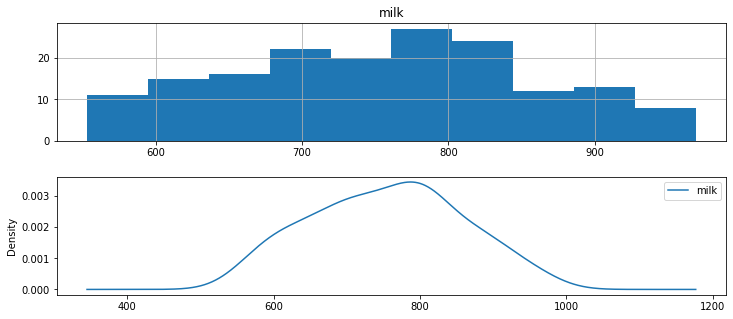

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,5))
df.hist(ax=ax1)
df.plot(kind='kde', ax=ax2)
plt.show();

In [9]:
time_series = df.milk


In [10]:
fig = go.Figure(data=go.Scatter(
    y = time_series,
    mode = 'lines'
))

fig.show()

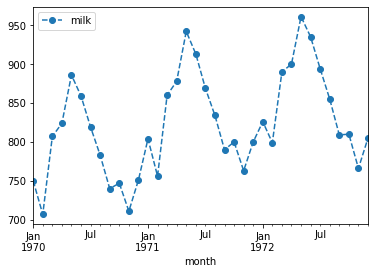

In [11]:
df['1970':'1972'].plot(style='o--');

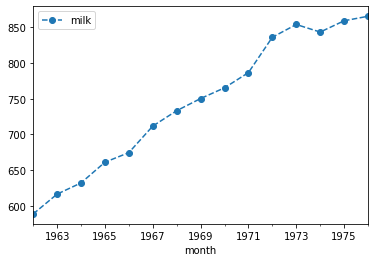

In [12]:
df.resample('12M').mean().plot(style='o--');

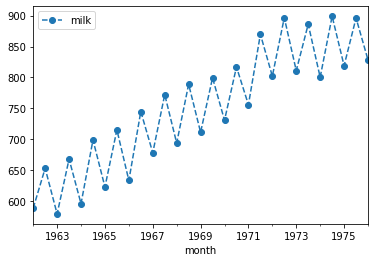

In [13]:
df.resample('6M').mean().plot(style='o--');

In [14]:

indices = find_peaks(time_series)[0]

fig = go.Figure()
fig.add_trace(go.Scatter(
    y=time_series,
    mode='lines+markers',
    name='Original Plot'
))

fig.add_trace(go.Scatter(
    x=indices,
    y=[time_series[j] for j in indices],
    mode='markers',
    marker=dict(
        size=8,
        color='red',
        symbol='cross'
    ),
    name='Detected Peaks'
))

fig.show()

In [15]:
from statsmodels.tsa.stattools import adfuller

X = df.iloc[:,0].values

result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.303812
p-value: 0.627427
Critical Values:
	1%: -3.474
	5%: -2.880
	10%: -2.577


In [16]:
from numpy import log

X = log(X)
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.754797
p-value: 0.403123
	1%: -3.474
	5%: -2.880
	10%: -2.577


In [17]:
df

,milk
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1975-08-01,858
1975-09-01,817
1975-10-01,827


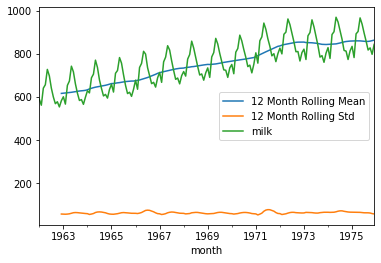

In [18]:


timeseries = df['milk']
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



<Figure size 432x288 with 0 Axes>

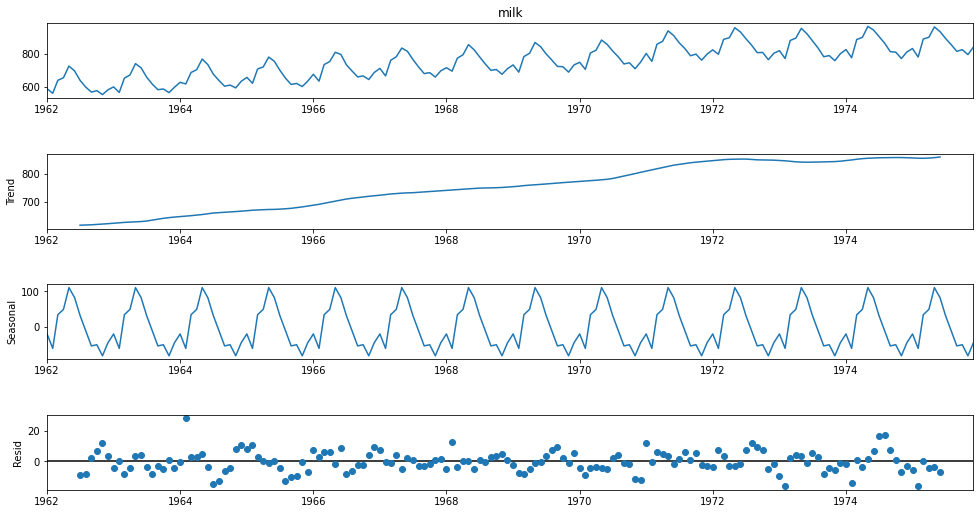

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['milk'], freq=12)  
figure = plt.figure()  
figure = decomposition.plot()  
figure.set_size_inches(15, 8)

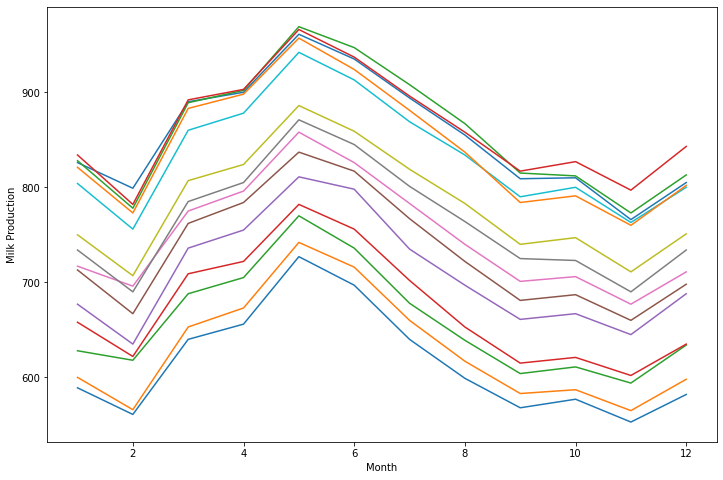

In [20]:
df['year'] = df.index.year
df['M'] = df.index.month
df_pivot = pd.pivot_table(df, values='milk', index='M', columns='year', aggfunc='mean')
df_pivot.plot(figsize=(12,8))
plt.legend().remove()
plt.xlabel('Month')
plt.ylabel('Milk Production')
plt.show()

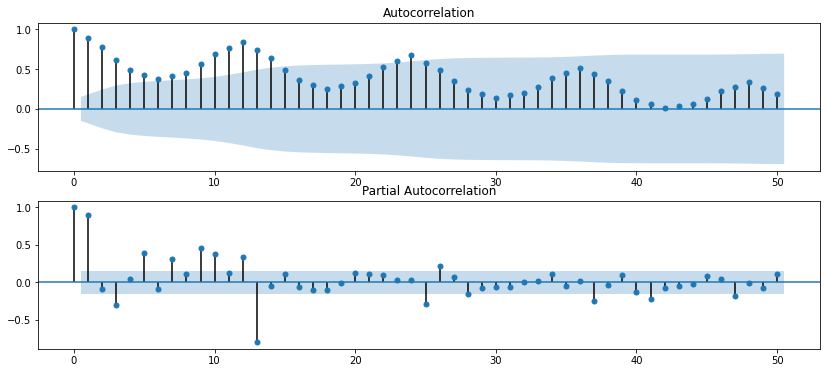

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(df.milk, lags=50, ax=ax1)
ax2 = plot_pacf(df.milk, lags=50, ax=ax2)
plt.show()

Stationary

In [22]:
df_diff = df.diff().diff(12)

In [23]:
df_diff.dropna(inplace=True)

In [24]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff['milk'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -5.038002
p-value                          0.000019
#Lags Used                      11.000000
Number of Observations Used    143.000000
Critical Value (1%)             -3.476927
Critical Value (5%)             -2.881973
Critical Value (10%)            -2.577665
dtype: float64


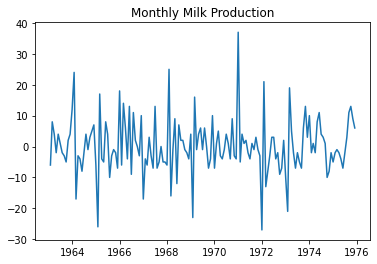

In [25]:
plt.plot(df_diff['milk'])
plt.title('Monthly Milk Production')
plt.savefig('diffplot')
plt.show()

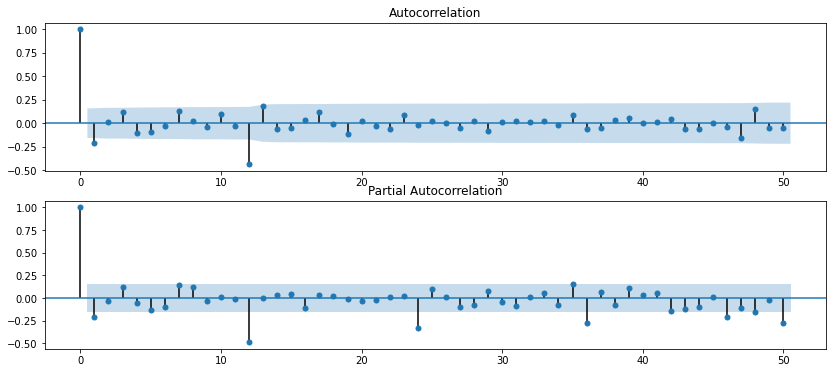

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(df_diff.milk, lags=50, ax=ax1)
ax2 = plot_pacf(df_diff.milk, lags=50, ax=ax2)
plt.savefig('acfpacf2')
plt.show()

Model

In [27]:
import pmdarima as pm
model = pm.auto_arima(df['milk'], d=1, D=1,
                      seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=6, test='adf', stepwise=True, trace=True)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1076.128, Time=0.50 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1121.939, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1083.569, Time=0.59 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1068.286, Time=0.61 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1116.950, Time=0.15 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1070.017, Time=0.85 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1069.963, Time=1.60 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1084.109, Time=0.56 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=4.93 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1074.277, Time=0.38 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1070.056, Time=0.82 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1069.791, Time=0.72 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1068.200, Time=0.50 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1116.800, Time=0.13 sec
 ARIMA(1,1,0)(1,1,1)[12]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1068.688, Time=2.09 sec
 ARIMA(1,1,0)(0,1,1)[12] intercept   : AIC=1068.200, Time=0.51 sec

Best model:  ARIMA(1,1,0)(0,1,1)[12]          
Total fit time: 22.102 seconds
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  168
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -530.100
Date:                              Sun, 09 Aug 2020   AIC                           1068.200
Time:                                      23:11:03   BIC                           1080.374
Sample:                                           0   HQIC                          1073.145
                                              - 168                                         
Covariance Type:                                opg                                         
                 coef    std err          z

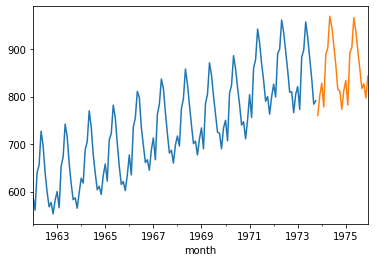

In [28]:
#divide into train and validation set
train = df[:int(0.85*(len(df)))]
test = df[int(0.85*(len(df))):]

#plotting the data
train['milk'].plot()
test['milk'].plot()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                      SARIMAX Results                                       
Dep. Variable:                                 milk   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -534.065
Date:                              Sun, 09 Aug 2020   AIC                           1074.131
Time:                                      23:12:27   BIC                           1083.261
Sample:                                  01-01-1962   HQIC                          1077.839
                                       - 12-01-1975                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.58

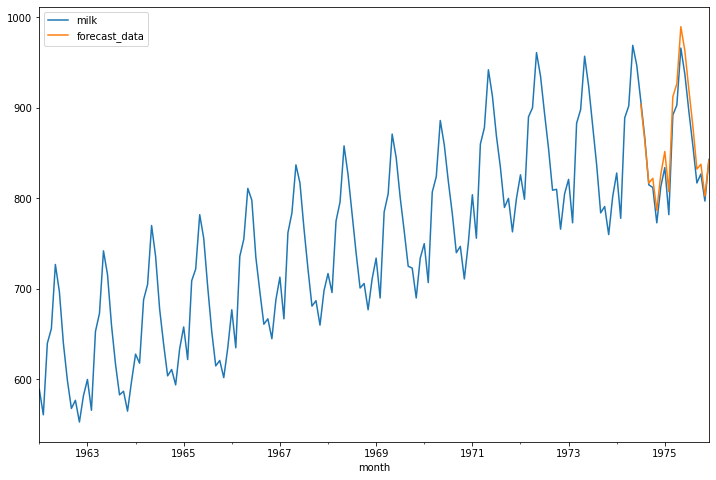

In [31]:
model = SARIMAX(df['milk'],order=(0,1,0), seasonal_order=(1,1,1,12))
ARIMAresult = model.fit()
print(ARIMAresult.summary())



df['forecast_data'] = ARIMAresult.predict(start = 150, end= 168, dynamic= True)  
df [['milk','forecast_data']].plot(figsize= (12,8))

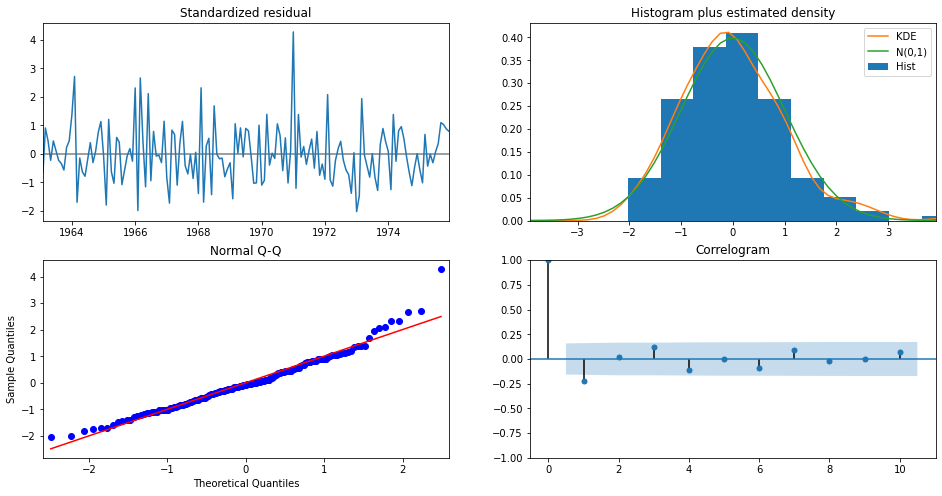

In [32]:
ARIMAresult.plot_diagnostics(figsize=(16, 8))
plt.savefig('modeldiagnostics')
plt.show()

In [33]:
forecast_object = ARIMAresult.get_forecast(steps=len(test))
mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()
dates = mean.index

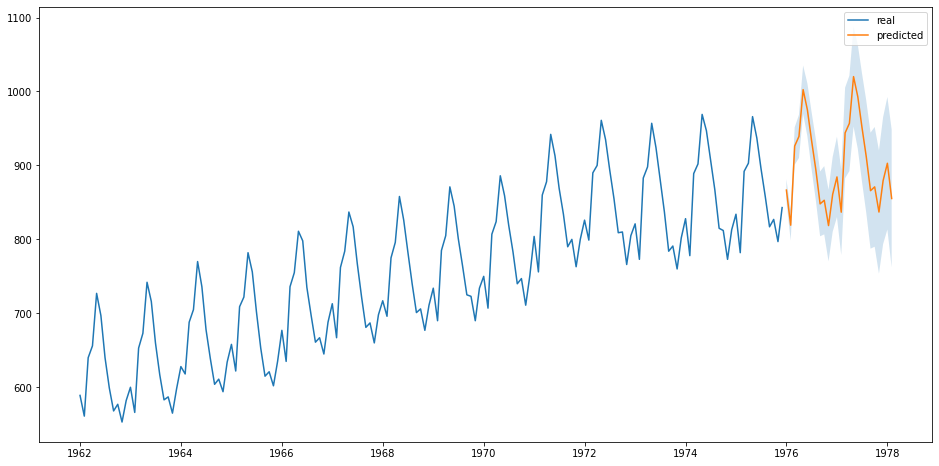

In [34]:
plt.figure(figsize=(16,8))
plt.plot(df.index, df.milk, label='real')
plt.plot(dates, mean, label='predicted')
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1],
alpha=0.2)


plt.legend()
plt.savefig('predtest')
plt.show()

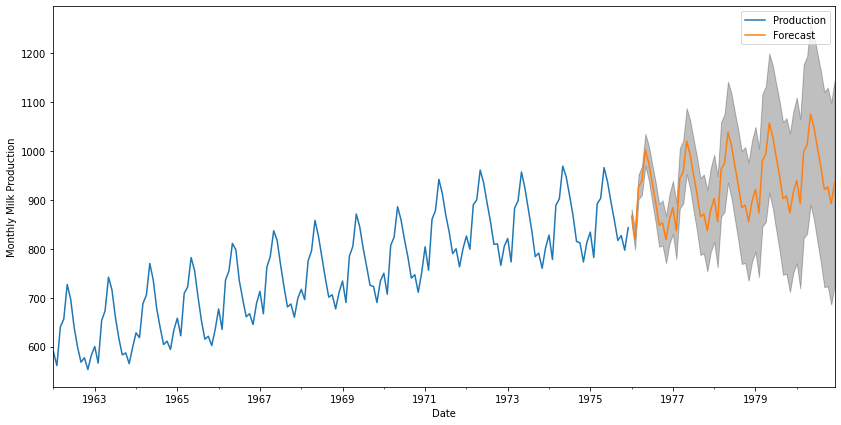

In [36]:
pred_f = ARIMAresult.get_forecast(steps=60)
pred_ci = pred_f.conf_int()
ax = df.milk.plot(label='Production', figsize=(14, 7))
pred_f.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Milk Production')
plt.legend()
plt.show()